In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract

# Reflect Tables into SQLAlchemy ORM

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Exploratory Precipitation Analysis

#### Open Session

In [5]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [6]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

#### Design a query to retrieve the last 12 months of precipitation data and plot the results,</br> starting from the most recent data point in the database. 

In [7]:
# Calculate the date one year previous
one_year_previous = dt.date.fromisoformat(most_recent_date) \
                    - dt.timedelta(days=365)

# Query data from Measurement table 
precip_year = session.query(Measurement.date, func.max(Measurement.prcp))\
    .filter(Measurement.date > one_year_previous)\
    .group_by(Measurement.date)\
    .order_by(Measurement.date)\
    .all()


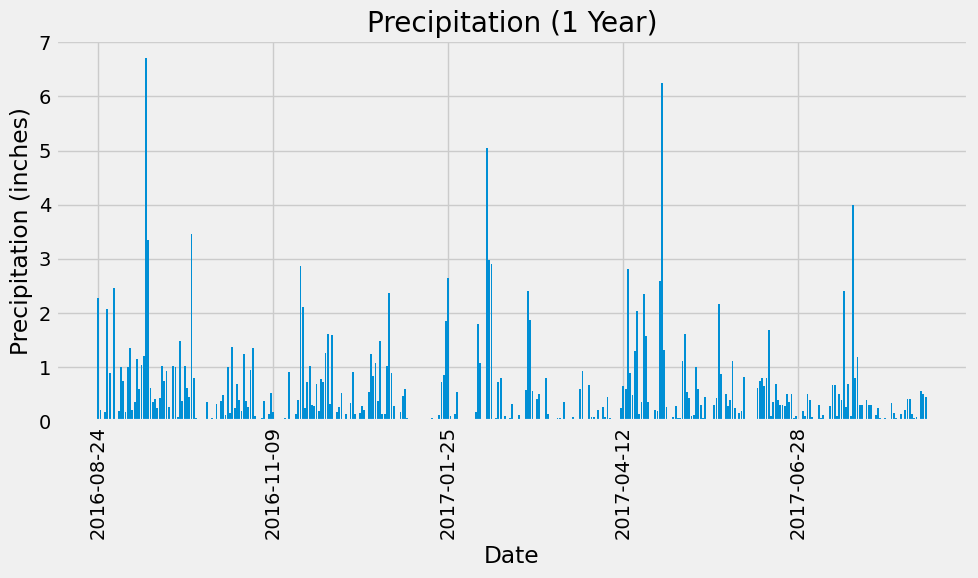

In [8]:
# Extracting x and y values from the data
x_values = [item[0] for item in precip_year]
y_values = [item[1] for item in precip_year]

# Set up the plot
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation (1 Year)')

# Adjust x-axis tick labels
start_date = one_year_previous
tick_interval = 77  

# Filter x_values and corresponding labels
filtered_x_values = [x for i, x in enumerate(x_values) if i % tick_interval == 0]
filtered_labels = [x for i, x in enumerate(x_values) if i % tick_interval == 0]

plt.xticks(filtered_x_values, filtered_labels, rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_summary = pd.DataFrame(session.query(Measurement.date, Measurement.prcp)\
                .filter(Measurement.date >= one_year_previous))
prcp_summary.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [10]:
# Design a query to calculate the total number of stations in the dataset
print('The number of Stations is: ', session.query(Station.station).count())

The number of Stations is:  9


In [11]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_counts = session.query(Measurement.station, func.count(Measurement.id).label('ct'))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.id).desc())\
                        .order_by('ct')\
                        .all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_stats = session.query(
    func.min(Measurement.tobs).label('mas_lo'),
    func.max(Measurement.tobs).label('mas_hi'),
    func.avg(Measurement.tobs).label('mas_avg')
).filter(Measurement.station == 'USC00519281').all()

mas_lo, mas_hi, mas_avg = most_active_stats[0]

print(f'Lowest Temp: {mas_lo}')
print(f'Highest Temp: {mas_hi}')
print(f'Average Temp: {mas_avg}')

Lowest Temp: 54.0
Highest Temp: 85.0
Average Temp: 71.66378066378067


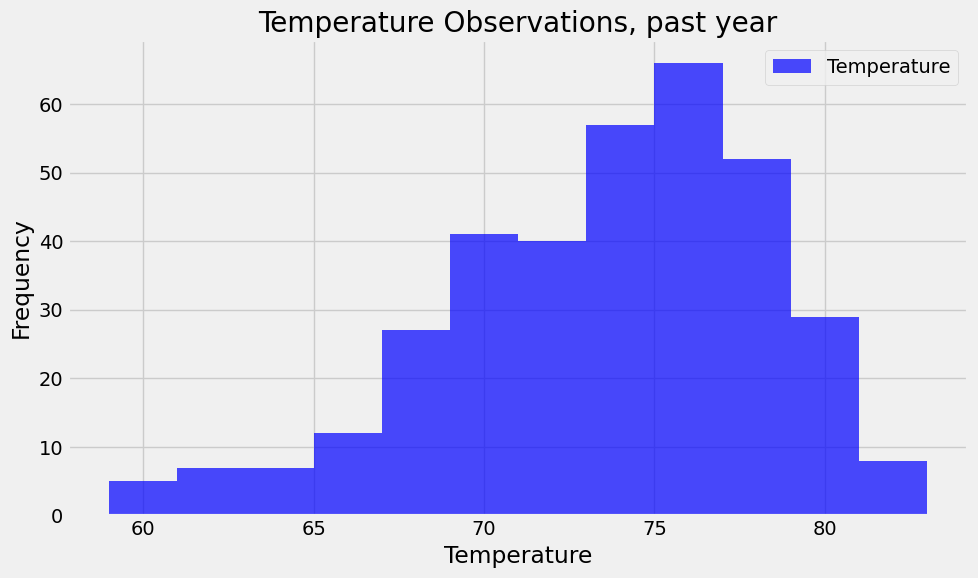

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to get temperature values from the most active station for the past year
mas_temp_1yr = session.query(Measurement.tobs)\
    .filter(Measurement.station == 'USC00519281')\
    .filter(Measurement.date > one_year_previous)\
    .all()

# Extract temperature values from the query result
temperatures = [result.tobs for result in mas_temp_1yr]

# Set up the plot
plt.figure(figsize=(10, 6))  

# Create a histogram of temperatures with 12 bins
plt.hist(temperatures, bins=12, color='blue', alpha=0.7)

# Configure the plot
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations, past year')
plt.legend(['Temperature'], loc='upper right')

# Show the plot
plt.tight_layout()  
plt.show()



### Close Session

In [ ]:
session.close()